# Imports

In [1]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import json
import os
from tqdm import tqdm

# Dataset

## Create Data

In [2]:
################################## For sample Data ##################################
def get_rays(datapath, mode="train"):

    pose_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/pose") if f.endswith(".txt")
    ]
    intrisics_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/intrinsics") if f.endswith(".txt")
    ]
    img_file_names = [f for f in os.listdir(datapath + "/imgs") if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f"/{mode}/pose/" + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f"/{mode}/intrinsics/" + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4:  # RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H * W, 3))
    rays_d = np.zeros((N, H * W, 3))
    target_px_values = images.reshape((N, H * W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


In [4]:
a,b,c = get_rays('./data_raw/fox')

/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_44577/4039139909.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0


In [10]:
################################## ns-process-data output ##################################

def get_rays(datapath):
    f = open(datapath)
    data = json.load(f)

    N = len(np.array(data["frames"]))

    # Make array for poses (placeholder)
    poses = np.zeros((N, 4, 4))

    # Make intrinsics array
    intrinsics = np.zeros((N, 4, 4))
    intrinsics[:, 0, 0] = data["fl_x"]
    intrinsics[:, 0, 2] = data["cx"]
    intrinsics[:, 1, 1] = data["fl_y"]
    intrinsics[:, 1, 2] = data["cy"]
    intrinsics[:, 2, 2] = 1
    intrinsics[:, 3, 3] = 1

    # Make images array
    images = []

    #! Temporary 10 images
    for i in tqdm(range(N), desc="Loading Images...", colour="red"):
        pose = np.array(data["frames"][i]["transform_matrix"], dtype=float)
        poses[i] = pose

        img = (
            imageio.imread(f"./ns_opt_res_ferrari/{data['frames'][i]['file_path']}")
            / 255.0
        )
        images.append(img[None, ...])

    print("Running concatenation...")
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    # For tranparent images
    if images.shape[3] == 4:  # RGBA ->  RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1])

    # Ray Origins
    rays_o = np.zeros((N, H * W, 3))
    # Ray Directions
    rays_d = np.zeros((N, H * W, 3))
    # Image target
    target_px_values = images.reshape((N, H * W, 3))

    for i in tqdm(range(N), desc="Generating rays...", colour="green"):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * f), axis=-1)

        # Accounting for theta (camera angle)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [11]:
a,b,c = get_rays("../data_raw/ns_opt_res_ferrari/")

Loading Images...:   0%|          | 0/223 [00:00<?, ?it/s]/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_25856/2015895753.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f"./ns_opt_res_ferrari/{data['frames'][i]['file_path']}")
Loading Images...: 100%|██████████| 223/223 [00:01<00:00, 201.48it/s]


Running concatenation...


Generating rays...: 100%|██████████| 223/223 [00:04<00:00, 48.26it/s]


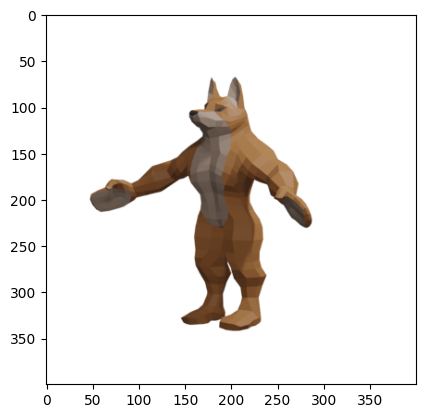

In [9]:
# Fox data: 400x400
# Ferrari data: 960x540
# HxW format
plt.imshow(c[3].reshape(400, 400, 3)[:, :, :3])

## Create Loader

### Live Processing

In [10]:
flat_data = torch.cat((torch.from_numpy(a).reshape(-1, 3),
                                   torch.from_numpy(b).reshape(-1, 3),
                                   torch.from_numpy(c).reshape(-1, 3)), dim=1).float() #? -> [n, [ray_o_x, ray_o_y, ray_o_z, ray_d_x, ray_d_y, ray_d_z, px_r, px_g, px_b]]

In [11]:
print(a.shape)
print(b.shape)
print(c.shape)

(90, 160000, 3)
(90, 160000, 3)
(90, 160000, 3)


In [12]:
dataloader = DataLoader(flat_data, batch_size=1000)

### Load Processed Data

In [21]:
load_data = np.load('./ferrari.npy')
dataloader = DataLoader(torch.from_numpy(load_data), batch_size=1200)

In [22]:
load_data.shape

array([[ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54509807,
         0.34901962,  0.21960784],
       [ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54509807,
         0.34901962,  0.21960784],
       [ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54901963,
         0.3529412 ,  0.22352941],
       ...,
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.8392157 ,
         0.8509804 ,  0.87058824],
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.84313726,
         0.85490197,  0.8745098 ],
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.84313726,
         0.85490197,  0.8745098 ]], dtype=float32)

# Models Implementation

## NeRF

In [2]:
import torch
import torch.nn as nn


class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # density estimation
        self.block2 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1),
        )
        # color estimation
        self.block3 = nn.Sequential(
            nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Linear(hidden_dim // 2, 3),
            nn.Sigmoid(),
        )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2**j * x))
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(
            o, self.embedding_dim_pos
        )  # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(
            d, self.embedding_dim_direction
        )  # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x)  # h: [batch_size, hidden_dim]
        tmp = self.block2(
            torch.cat((h, emb_x), dim=1)
        )  # tmp: [batch_size, hidden_dim + 1]
        h, sigma = tmp[:, :-1], self.relu(
            tmp[:, -1]
        )  # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(
            torch.cat((h, emb_d), dim=1)
        )  # h: [batch_size, hidden_dim // 2]
        c = self.block4(h)  # c: [batch_size, 3]
        return c, sigma


## K-Planes

In [17]:
import torch
import torch.nn as nn
import numpy as np


class NerfModel(nn.Module):
    def __init__(
        self, embedding_dim_direction=4, hidden_dim=64, N=512, F=96, scale=1.5
    ):
        """
        The parameter scale represents the maximum absolute value among all coordinates and is used for scaling the data
        """
        super(NerfModel, self).__init__()

        self.xy_plane = nn.Parameter(torch.rand((N, N, F)))
        self.yz_plane = nn.Parameter(torch.rand((N, N, F)))
        self.xz_plane = nn.Parameter(torch.rand((N, N, F)))

        self.block1 = nn.Sequential(
            nn.Linear(F, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(15 + 3 * 4 * 2 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3),
            nn.Sigmoid(),
        )

        self.embedding_dim_direction = embedding_dim_direction
        self.scale = scale
        self.N = N

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2**j * x))
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    def forward(self, x, d):
        sigma = torch.zeros_like(x[:, 0])
        c = torch.zeros_like(x)

        mask = (
            (x[:, 0].abs() < self.scale)
            & (x[:, 1].abs() < self.scale)
            & (x[:, 2].abs() < self.scale)
        )
        xy_idx = (
            ((x[:, [0, 1]] / (2 * self.scale) + 0.5) * self.N)
            .long()
            .clip(0, self.N - 1)
        )  # [batch_size, 2]
        yz_idx = (
            ((x[:, [1, 2]] / (2 * self.scale) + 0.5) * self.N)
            .long()
            .clip(0, self.N - 1)
        )  # [batch_size, 2]
        xz_idx = (
            ((x[:, [0, 2]] / (2 * self.scale) + 0.5) * self.N)
            .long()
            .clip(0, self.N - 1)
        )  # [batch_size, 2]
        F_xy = self.xy_plane[xy_idx[mask, 0], xy_idx[mask, 1]]  # [batch_size, F]
        F_yz = self.yz_plane[yz_idx[mask, 0], yz_idx[mask, 1]]  # [batch_size, F]
        F_xz = self.xz_plane[xz_idx[mask, 0], xz_idx[mask, 1]]  # [batch_size, F]
        F = F_xy * F_yz * F_xz  # [batch_size, F]

        h = self.block1(F)
        h, sigma[mask] = h[:, :-1], h[:, -1]
        c[mask] = self.block2(
            torch.cat(
                [self.positional_encoding(d[mask], self.embedding_dim_direction), h],
                dim=1,
            )
        )
        return c, sigma


In [ ]:
if __name__ == "__main__":
    device = "mps"
    # training_dataset = torch.from_numpy(
    #     np.load("./training_data_.pkl", allow_pickle=True)
    # )

    # testing_dataset = torch.from_numpy(np.load("./testing_data.pkl", allow_pickle=True))
    model = NerfModel(hidden_dim=256).to(device)
    # model = torch.load("./nerf_model_plex", map_location=torch.device("mps"))
    model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        model_optimizer, milestones=[2, 4, 8], gamma=0.5
    )

    data_loader = dataloader
    # data_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
    ac = train(
        model,
        model_optimizer,
        scheduler,
        data_loader,
        nb_epochs=14,
        device=device,
        hn=8,
        hf=12,
        nb_bins=100,
    )

    # for img_index in range(200):
    #     test(8, 12, dataloader, img_index=img_index, nb_bins=100, H=400, W=400)


In [ ]:
plt.imshow(torch.cat(ac).detach().cpu().numpy().reshape(400,400,3))

# Rendering

## Prepare Input Rays

In [41]:
H = W = 400
idx = 4

o = flat_data[idx*H*W:(idx+1)*H*W, :3].float() # 1 img -> [i: i+H*W, :3]
d = flat_data[idx*H*W:(idx+1)*H*W, 3:6].float() # 1 img -> [i: i+H*W, 3:6]

target = flat_data[idx*H*W:(idx+1)*H*W, 6:].float()

model = torch.load('../Nerf_testing/NeRF_100/nerf_model_fox', map_location='mps')

o.shape

torch.Size([160000, 3])

In [50]:
# Target Image
target_img = target.reshape(400, 400, 3)
target_img = target_img.detach().cpu().numpy()

## Generate Output

100%|██████████| 20/20 [00:12<00:00,  1.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


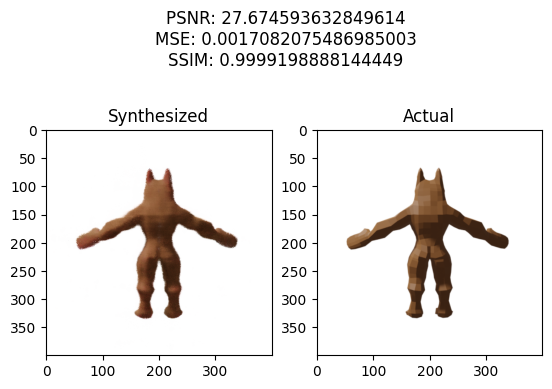

In [73]:
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity
from skimage.color import rgb2gray

chunk_size = 20 # Rendering part by part
device = torch.device('mps')
img_reg = []

#! IMPORTANT
with torch.no_grad():
    for i in tqdm(range(int(np.ceil(400 / chunk_size)))):
        ray_origins_ = o[i * 400 * chunk_size : (i + 1) * 400 * chunk_size].to(device)
        ray_directions_ = d[i * 400 * chunk_size : (i + 1) * 400 * chunk_size].to(device)
        
        regenerated_px_values = render_rays(
            model, ray_origins_, ray_directions_, hn=8, hf=12, nb_bins=100
        )
        
        img_reg.append(regenerated_px_values)

img = torch.cat(img_reg).data.cpu().numpy().reshape(400, 400, 3)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Synthesized")
ax[1].imshow(target_img)
ax[1].set_title("Actual")

psnr = peak_signal_noise_ratio(target_img, img)
mse = mean_squared_error(target_img, img)
ssim = structural_similarity(rgb2gray(target_img), rgb2gray(img), data_range=255)

fig.suptitle(f"PSNR: {psnr}\nMSE: {mse}\nSSIM: {ssim}")

In [71]:
psnr = peak_signal_noise_ratio(target_img, img)
mse = mean_squared_error(target_img, img)
ssim = structural_similarity(rgb2gray(target_img), rgb2gray(img), data_range=255)

print(f"PSNR: {psnr}")
print(f"MSE: {mse}")
print(f"SSIM: {ssim}")

PSNR: 27.71269242682877
MSE: 0.0016932877141683966
SSIM: 0.9999203302568818


# Mesh Extraction

In [11]:
import mcubes
import trimesh

In [26]:
device = 'mps'
# tn = 8.
# tf = 12.
tn = 2.
tf = 6.
model = torch.load('./models/nerf_model_plex_6.pth').to(device)

In [27]:
N = 100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))

In [28]:
xyz = torch.cat((x.reshape(-1, 1),
                 y.reshape(-1, 1),
                 z.reshape(-1, 1)), dim=1)

In [29]:
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))
    
density = density.cpu().numpy().reshape(N, N, N)

In [30]:
vertices, triangles = mcubes.marching_cubes(density, 30 * np.mean(density))

In [31]:
mesh = trimesh.Trimesh(vertices / N, triangles)

In [32]:
mesh.show()